In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

In [4]:
etfs = [
    'SPY', 'GLD', 'SLV', 'XLE', 'XLF', 'XLI', 'XLV', 'XLY', 'XLU',
    'XLRE', 'TLT', 'EEM', 'IWM', 'VEA', 'VWO', 'VNQ', 'TIP', 'HYG',
    'XLB', 'XLP', 'XPS', 'XBI', 'XRT', 'XHB', 'KRE', 'XLC', 'SPG',
    'DIA', 'IVV', 'VTI', 'VUG', 'VTV', 'VOO', 'VYM', 'BND', 'LQD', 'JNK', 'XLK', 'QQQ'
]

data = yf.download(etfs, '2015-01-01')['Adj Close']

[*********************100%***********************]  39 of 39 completed

1 Failed download:
['XPS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-10-02)')


In [5]:
returns = data.pct_change()[1:]
pairs = [(etf) for etf in etfs if etf != 'SPY']
ratios = pd.DataFrame({pair: data['SPY'] / data[pair] for pair in pairs})

C:\Users\juana\AppData\Local\Temp\ipykernel_20104\4286456074.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change()[1:]


In [6]:
signals = pd.DataFrame(index=ratios.index)
for window in range(10,101,10):
    ma = ratios.rolling(window=window).mean()
    for pair in pairs:
        signal_col = f'Signal_{pair}_MA_{window}'
        signals[signal_col] = np.where(ratios[pair] > ma[pair], 1, np.where(ratios[pair] < ma[pair], -1, 0))

C:\Users\juana\AppData\Local\Temp\ipykernel_20104\2611893199.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  signals[signal_col] = np.where(ratios[pair] > ma[pair], 1, np.where(ratios[pair] < ma[pair], -1, 0))
C:\Users\juana\AppData\Local\Temp\ipykernel_20104\2611893199.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  signals[signal_col] = np.where(ratios[pair] > ma[pair], 1, np.where(ratios[pair] < ma[pair], -1, 0))
C:\Users\juana\AppData\Local\Temp\ipykernel_20104\2611893199.py:6: PerformanceWarning: DataFrame is highly

In [7]:
signals = signals.shift(1)
signals.dropna(inplace=True)

In [8]:
strategy_returns = pd.DataFrame(index=signals.index)
transaction_cost_pct = 0

In [9]:
for pair in pairs:
    spy_returns = returns['SPY']
    etf_returns = returns[pair]
    for window in range(10,31,10):
        signal_col = f'Signal_{pair}_MA_{window}'
        switch_points = signals[signal_col].diff().fillna(0) != 0
        strategy_returns[f'{pair}_MA_{window}'] = (np.where(signals[signal_col] == 1, 
                                                            spy_returns - transaction_cost_pct * switch_points.astype(int),
                                                            etf_returns - transaction_cost_pct * switch_points.astype(int))
                                                    )

cummulative_returns = (1 + strategy_returns).cumprod()
buy_hold_returns = (1 + returns).cumprod()

C:\Users\juana\AppData\Local\Temp\ipykernel_20104\2988212134.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  strategy_returns[f'{pair}_MA_{window}'] = (np.where(signals[signal_col] == 1,
C:\Users\juana\AppData\Local\Temp\ipykernel_20104\2988212134.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  strategy_returns[f'{pair}_MA_{window}'] = (np.where(signals[signal_col] == 1,
C:\Users\juana\AppData\Local\Temp\ipykernel_20104\2988212134.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [10]:
final_cummulative_returns = cummulative_returns.iloc[-1]
top_10_strategies = final_cummulative_returns.nlargest(25).index

Text(0.5, 1.0, 'Top 25 Strategies vs SPY Buy and Hold')

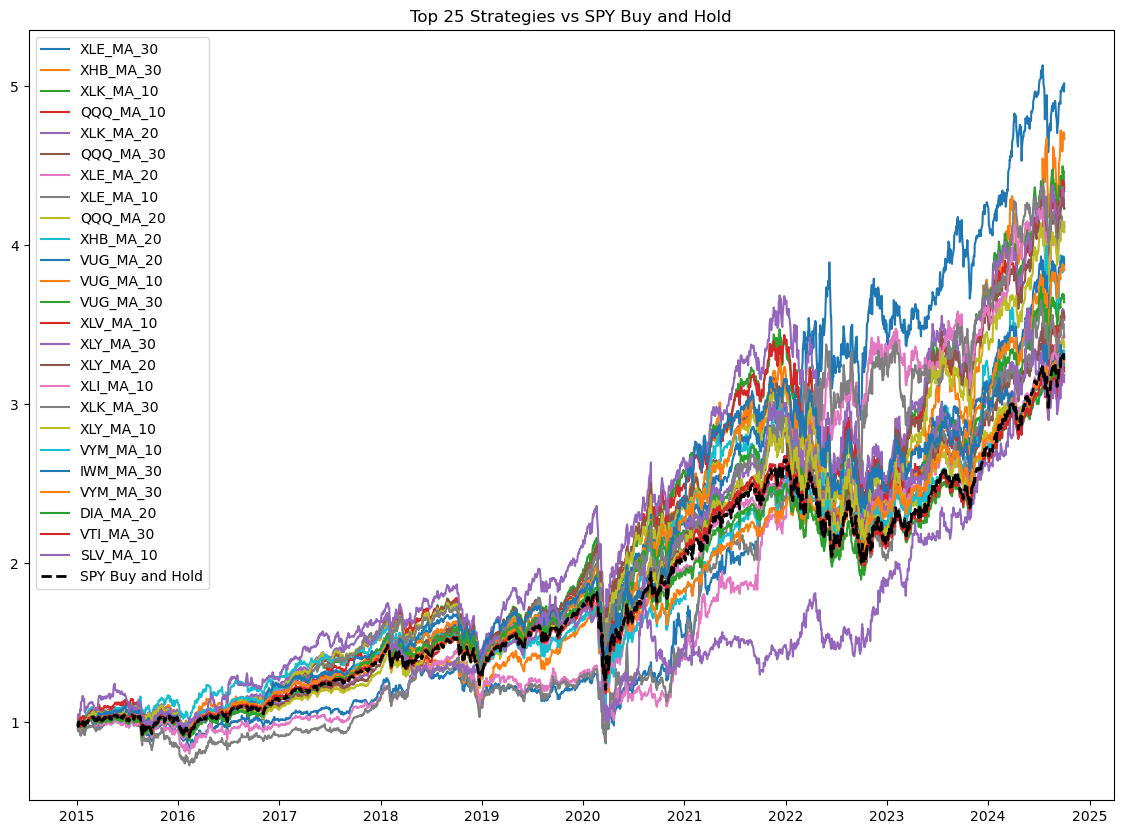

In [12]:
plt.figure(figsize=(14,10))
for strat in top_10_strategies:
    plt.plot(cummulative_returns[strat], label=f'{strat}')
plt.plot(buy_hold_returns['SPY'], label='SPY Buy and Hold', color='black', linewidth=2, linestyle='--')
plt.legend()
plt.title('Top 25 Strategies vs SPY Buy and Hold')